# MIMIC-II IAC Causal Inference

This tutorial continues the exploration the MIMIC-II IAC dataset using causal inference methods. The dataset was created for the purpose of a case study in the book: Secondary Analysis of Electronic Health Records, published by Springer in 2016. In particular, the dataset was used throughout Chapter 16 (Data Analysis) by Raffa J. et al. to investigate the effectiveness of indwelling arterial catheters in hemodynamically stable patients with respiratory failure for mortality outcomes. The dataset is derived from MIMIC-II, the publicly-accessible critical care database. It contains summary clinical data and  outcomes for 1,776 patients.

Reference: 

[1] https://github.com/py-why/dowhy

[2] https://www.pywhy.org/dowhy/

[3] https://arxiv.org/abs/2011.04216

[4] https://physionet.org/content/mimic2-iaccd/1.0/

## Importing ehrapy and setting plotting parameters

In [1]:
import ehrapy as ep
from IPython.display import display
import graphviz

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
ep.print_versions()

-----
ehrapy              0.9.0
rich                NA
scanpy              1.9.3
session_info        1.0.0
-----
CoreFoundation              NA
Foundation                  NA
Levenshtein                 0.21.1
PIL                         10.0.0
PyObjCTools                 NA
anndata                     0.9.2
anyio                       NA
appnope                     0.1.3
argcomplete                 NA
arrow                       1.2.3
astor                       0.8.1
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
autograd                    NA
autograd_gamma              NA
babel                       2.12.1
backcall                    0.2.0
brotli                      1.0.9
cachetools                  5.3.1
causallearn                 NA
certifi                     2023.07.22
cffi                        1.15.1
charset_normalizer          3.2.0
cloudpickle                 2.2.1
comm                        0.1.3
cvxopt             

## MIMIC-II dataset preparation
Let's load the MIMIC-II dataset using ehrapy with default one-hot encoding.

In [4]:
adata = ep.dt.mimic_2(encoded=True)

Output()

The MIMIC-II dataset has 1776 patients as described above with 46 features.

In [5]:
adata

AnnData object with n_obs × n_vars = 1776 × 54
    obs: 'service_unit', 'day_icu_intime'
    var: 'feature_type', 'unencoded_var_names', 'encoding_mode'
    layers: 'original'

## Causal Inference on the MIMIC-II dataset
In the background, `ehrapy` uses the [dowhy](https://github.com/py-why/dowhy) package to enable effortless causal inference on electronic health records (EHR). Any `dowhy` analysis is structured into 3 steps:
1) Formulate causal questions
2) Estimate causal effects
3) Perform refutation tests.


### Causal Graph

The causal graph is a directed acyclic graph (DAG) that represents the causal relationships between the variables in the dataset. Here, we create it by manually writing out the connections between the variables. Other options would be the GML or DOT graph format. Furthermore, you can use graphical tools like [DAGitty](http://dagitty.net/dags.html) to construct the graph. You can export the graph string that it generates. The graph string is very close to the DOT format: just rename dag to digraph, remove newlines and add a semicolon after every line, to convert it to the DOT format and input to DoWhy.

#### Assumptions:
 - both age and overweight increase your risk for medical problems
 - having a lot of problems makes you more likely to die in the hospital
 - having a lot of problems influences your likelihood of getting an IAC
 - having an IAC influences your likelihood of dying in the hospital

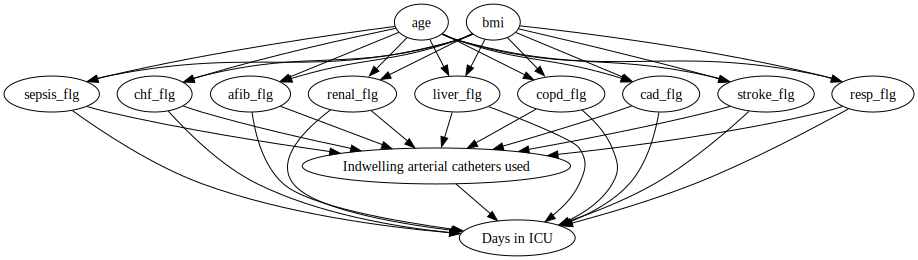

In [6]:
causal_graph = """digraph {
aline_flg[label="Indwelling arterial catheters used"];
icu_los_day[label="Days in ICU"];

age -> sepsis_flg;
age -> chf_flg;
age -> afib_flg;
age -> renal_flg;
age -> liver_flg;
age -> copd_flg;
age -> cad_flg;
age -> stroke_flg;
age -> resp_flg;
bmi -> sepsis_flg;
bmi -> chf_flg;
bmi -> afib_flg;
bmi -> renal_flg;
bmi -> liver_flg;
bmi -> copd_flg;
bmi -> cad_flg;
bmi -> stroke_flg;
bmi -> resp_flg;
sepsis_flg -> aline_flg;
chf_flg -> aline_flg;
afib_flg -> aline_flg;
renal_flg -> aline_flg;
liver_flg -> aline_flg;
copd_flg -> aline_flg;
cad_flg -> aline_flg;
stroke_flg -> aline_flg;
resp_flg -> aline_flg;
sepsis_flg -> icu_los_day;
chf_flg -> icu_los_day;
afib_flg -> icu_los_day;
renal_flg -> icu_los_day;
liver_flg -> icu_los_day;
copd_flg -> icu_los_day;
cad_flg -> icu_los_day;
stroke_flg -> icu_los_day;
resp_flg -> icu_los_day;
aline_flg -> icu_los_day;
}"""

g = graphviz.Source(causal_graph)
display(g)

### Causal inference

This graph can now be fed into the `causal_inference()` method. Furthermore, we have to specify an `estimation_method`. For now, we will use `backdoor.linear_regression`.
Please refer to [this example notebook](https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/dowhy_estimation_methods.ipynb) and the [official dowhy documentation](https://www.pywhy.org/dowhy/) for more information on the different estimation methods. 

In [7]:
ep.tl.causal_inference(
    adata=adata,
    graph=causal_graph,
    treatment="aline_flg",
    outcome="icu_los_day",
    estimation_method="backdoor.linear_regression",
)

❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (1/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (2/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (3/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (4/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (5/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (6/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (7/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (8/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (9/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (10/10)
Causal inference results for treatment variable 'aline_flg' and outcome variable 'icu_los_day':
└- Increasing the treatment variable(s) [al

As we can see, the model returns a summary of the identified causal effect and the refutation results. The `placebo_treatment_refuter` failed in this case because our intervention variable is binary. By default, all 6 potential refutation methods are run, but the user can also specify to only use a subset of them.

In [8]:
ep.tl.causal_inference(
    adata=adata,
    graph=causal_graph,
    treatment="aline_flg",
    outcome="icu_los_day",
    estimation_method="backdoor.linear_regression",
    refute_methods=[
        "placebo_treatment_refuter",  
        "random_common_cause",
        "data_subset_refuter",
        "add_unobserved_common_cause",
        "bootstrap_refuter",
        "dummy_outcome_refuter",
    ],
)

❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (1/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (2/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (3/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (4/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (5/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (6/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (7/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (8/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (9/10)
❗ Refutation 'placebo_treatment_refuter' returned invalid pval 'nan', retrying (10/10)
Causal inference results for treatment variable 'aline_flg' and outcome variable 'icu_los_day':
└- Increasing the treatment variable(s) [al

By default, we are hiding a lot of the default `dowhy` output for clarity. However, it is possible to nontheless display it.

In [9]:
ep.tl.causal_inference(
    adata=adata,
    graph=causal_graph,
    treatment="aline_flg",
    outcome="icu_los_day",
    estimation_method="backdoor.linear_regression",
    refute_methods=[
        # "placebo_treatment_refuter",  # we know it'll fail
        "random_common_cause",
        "data_subset_refuter",
        "add_unobserved_common_cause",
        "bootstrap_refuter",
        "dummy_outcome_refuter",
    ],
    print_causal_estimate=True,
    print_summary=False,
)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(E[icu_los_day|stroke_flg,copd_flg,sepsis_flg,liver_flg,resp_flg,c
d[aline_flg]                                                                  

                                   
ad_flg,chf_flg,renal_flg,afib_flg])
                                   
Estimand assumption 1, Unconfoundedness: If U→{aline_flg} and U→icu_los_day then P(icu_los_day|aline_flg,stroke_flg,copd_flg,sepsis_flg,liver_flg,resp_flg,cad_flg,chf_flg,renal_flg,afib_flg,U) = P(icu_los_day|aline_flg,stroke_flg,copd_flg,sepsis_flg,liver_flg,resp_flg,cad_flg,chf_flg,renal_flg,afib_flg)

## Realized estimand
b: icu_los_day~aline_flg+stroke_flg+copd_flg+sepsis_flg+liver_flg+resp_flg+cad_flg+chf_flg+renal_flg+afib_flg
Target units: ate

## Estimate
Mean value: 2.234881309168318

## Plotting 
Furthermore, the `causal_inference()` function can generate several plots, if desired. It's for example possible to output the causal graph ...

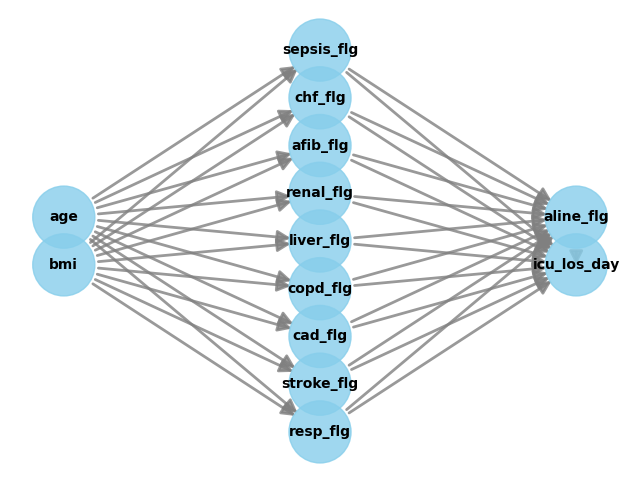

In [10]:
ep.tl.causal_inference(
    adata=adata,
    graph=causal_graph,
    treatment="aline_flg",
    outcome="icu_los_day",
    estimation_method="backdoor.linear_regression",
    refute_methods=[
        # "placebo_treatment_refuter",  # we know it'll fail
        "random_common_cause",
        "data_subset_refuter",
        "add_unobserved_common_cause",
        "dummy_outcome_refuter",
    ],
    print_causal_estimate=False,
    print_summary=False,
    show_graph=True,
)



... or the graph generated by the add_unobserved_common_cause refutation method.

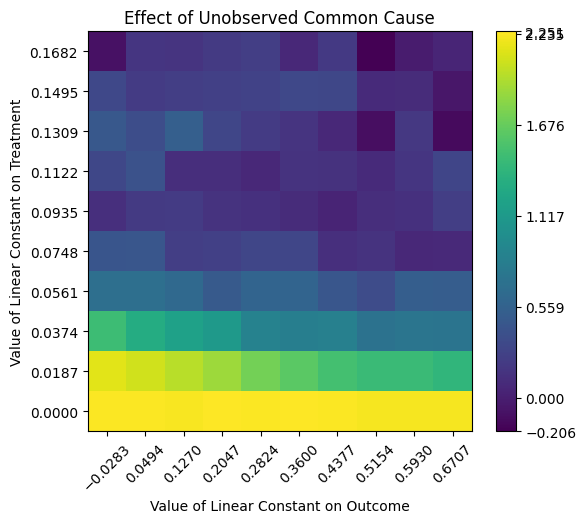

In [11]:
ep.tl.causal_inference(
    adata=adata,
    graph=causal_graph,
    treatment="aline_flg",
    outcome="icu_los_day",
    estimation_method="backdoor.linear_regression",
    refute_methods=[
        # "placebo_treatment_refuter",  # we know it'll fail
        "random_common_cause",
        "data_subset_refuter",
        "add_unobserved_common_cause",
        "dummy_outcome_refuter",
    ],
    print_causal_estimate=False,
    print_summary=False,
    show_graph=False,
    show_refute_plots=True,
)

In the process of performing the causal `dowhy` analysis, an estimator is created which we can query from the model and then visualise.

In [12]:
estimate = ep.tl.causal_inference(
    adata=adata,
    graph=causal_graph,
    treatment="aline_flg",
    outcome="icu_los_day",
    estimation_method="backdoor.linear_regression",
    refute_methods=[
        # "placebo_treatment_refuter",  # we know it'll fail
        "random_common_cause",
        "data_subset_refuter",
        "add_unobserved_common_cause",
        "bootstrap_refuter",
        "dummy_outcome_refuter",
    ],
    print_causal_estimate=False,
    print_summary=False,
    show_graph=False,
    show_refute_plots=False,
    return_as="estimate",
)

<Axes: title={'center': 'DoWhy estimate $\\rho$ (slope) = 2.235'}, xlabel='aline_flg', ylabel='icu_los_day'>

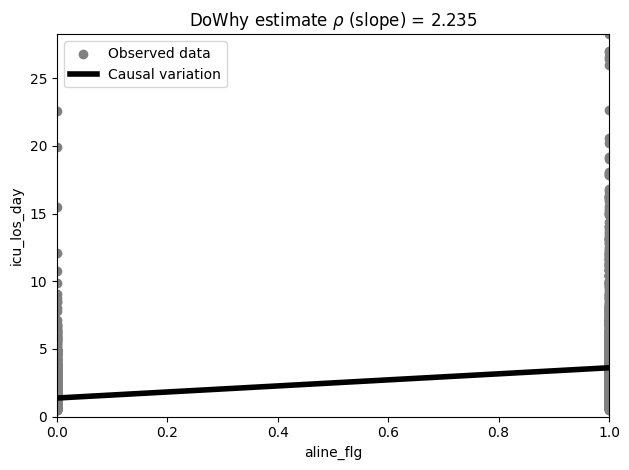

In [13]:
ep.pl.causal_effect(estimate)

## Advanced options
Within `dowhy`, the user can specify several arguments for identification, estimation and refutation. These arguments can also be passed directly to the respective functions through the `identify_kwargs`, `estimate_kwargs` and `refute_kwarg` of `causal_inference()`.

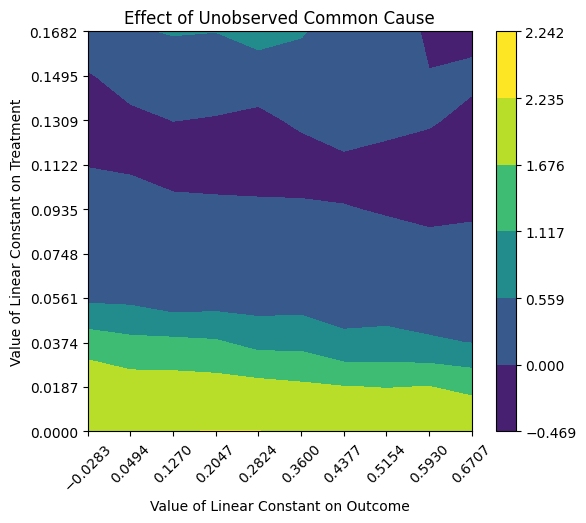

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(E[icu_los_day|stroke_flg,copd_flg,sepsis_flg,liver_flg,resp_flg,c
d[aline_flg]                                                                  

                                   
ad_flg,chf_flg,renal_flg,afib_flg])
                                   
Estimand assumption 1, Unconfoundedness: If U→{aline_flg} and U→icu_los_day then P(icu_los_day|aline_flg,stroke_flg,copd_flg,sepsis_flg,liver_flg,resp_flg,cad_flg,chf_flg,renal_flg,afib_flg,U) = P(icu_los_day|aline_flg,stroke_flg,copd_flg,sepsis_flg,liver_flg,resp_flg,cad_flg,chf_flg,renal_flg,afib_flg)

## Realized estimand
b: icu_los_day~aline_flg+stroke_flg+copd_flg+sepsis_flg+liver_flg+resp_flg+cad_flg+chf_flg+renal_flg+afib_flg
Target units: days

## Estimate
Mean value: 2.23488130916831

In [14]:
estimate = ep.tl.causal_inference(
    adata=adata,
    graph=causal_graph,
    treatment="aline_flg",
    outcome="icu_los_day",
    estimation_method="backdoor.linear_regression",
    refute_methods=[
        # "placebo_treatment_refuter",  # we know it'll fail
        "random_common_cause",
        "data_subset_refuter",
        "add_unobserved_common_cause",
        "bootstrap_refuter",
        "dummy_outcome_refuter",
    ],
    print_causal_estimate=True,
    print_summary=True,
    show_graph=False,
    show_refute_plots="contour",
    return_as="estimate",
    identify_kwargs={"proceed_when_unidentifiable": True},
    estimate_kwargs={"target_units": "days"},
    refute_kwargs={"random_seed": 5},
)